In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import os
from scipy.linalg import block_diag
#from LQR.lqr import LQR_inf # TODO: implement 
from GPC.gpc import GradientPerturbationController
from GPC.gpcwSTUSignal import GPCwSTU
from GPC.gpc_old import GPC_OLD
from OSFC.osfc import OnlineSpectralFilteringController
from OSFC.osfcNF import OSC # new updated
from OSFC.osfcNFwSTU import OSCwSTU # new updated
from utils import make_diagonalizable_matrix, make_positive_semidefinite, plot_loss, compare_losses, make_diagonalizable_matrix_complex, get_hankel_new
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
# LQR --- TODO: IMPLEMENT

# n, m = 10,4  

# A = make_diagonalizable_matrix(n)
# B = np.random.randn(n, m)
# Q = make_positive_semidefinite(n)
# R = make_positive_semidefinite(m)

# # Base dimensions
# # dx_base, du_base = 2, 1
# # blocks = 1  # So final dx = 2 * 5 = 10, du = 1 * 5 = 5

# # # Define small system matrices
# # A_small = np.array([[1.0, 1.0], [0.0, 1.0]]) # marginally stable (all eigenvals = 1)
# # B_small = np.array([[0.0], [1.0]])
# # Q_small = np.eye(dx_base) # symm PSD
# # R_small = np.eye(du_base) # symm PSD

# # # Create block-diagonal matrices
# # A = block_diag(*([A_small] * blocks))     # Shape (10, 10)
# # B = block_diag(*([B_small] * blocks))     # Shape (10, 5)
# # Q = block_diag(*([Q_small] * blocks))     # Shape (10, 10)
# # R = block_diag(*([R_small] * blocks))     # Shape (5, 5)


# T = 100

# lqr = LQR_inf(A, B, Q, R, name="LQR")

# start_time = time.time()
# lqr.run(T)
# end_time = time.time()
# print(f"LQR Model Runtime: {end_time - start_time:.4f} seconds")

# plot_loss(lqr, "LQR Loss")

NameError: name 'LQR_inf' is not defined

/home/sd0937/spectral_control/spectral_control/GPC/gpcwSTUSignal.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("K", torch.tensor(lqr(A, B, Q, R), dtype=torch.float32))


GPC_w_STU Model Runtime: 28.3188 seconds


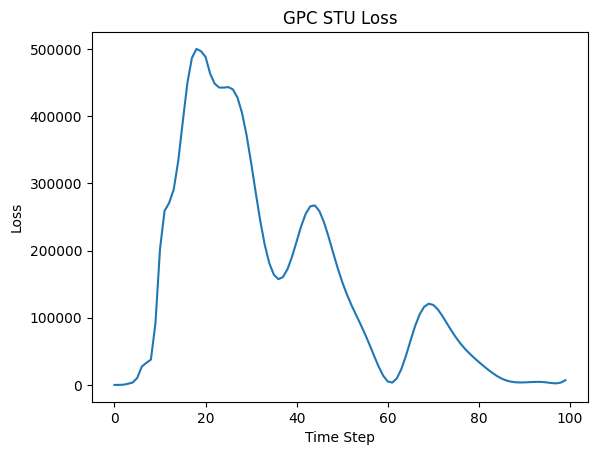

In [57]:
# GPC Experiments (Main GPC is from gpc.py and STU one is in gpcwSTUSignal.py)

n, m = 10,4 # State dimension

A = make_diagonalizable_matrix(n)
# A_compl = make_diagonalizable_matrix_complex(n)
B = np.random.randn(n, m)
Q = make_positive_semidefinite(n)
R = make_positive_semidefinite(m)


# Base dimensions
# dx_base, du_base = 2, 1
# blocks = 5  # So final dx = 2 * 5 = 10, du = 1 * 5 = 5

# # Define small system matrices
# A_small = np.array([[1.0, 1.0], [0.0, 1.0]])
# B_small = np.array([[0.0], [1.0]])
# Q_small = np.eye(dx_base)
# R_small = np.eye(du_base)

# # Create block-diagonal matrices
# A = block_diag(*([A_small] * blocks))     # Shape (10, 10)
# B = block_diag(*([B_small] * blocks))     # Shape (10, 5)
# Q = block_diag(*([Q_small] * blocks))     # Shape (10, 10)
# R = block_diag(*([R_small] * blocks))     # Shape (5, 5)

# PARAMETERS
h = 5  # Memory length
eta = 0.001  # Learning rate
T= 100

gpc = GradientPerturbationController(A, B, Q, R, h, eta, T, name="GPC", nl=False)
gpc_nl = GradientPerturbationController(A, B, Q, R, h, eta, T, name="GPC NL", nl=True)
gpc_wstu = GPCwSTU(A, B, Q, R, h, eta, T, name="GPC STU", nl=False)


# GPC
# start_time = time.time()
# gpc.run()
# end_time = time.time()
# print(f"GPC Model Runtime: {end_time - start_time:.4f} seconds")

# # GPC_NL
# start_time = time.time()
# gpc_nl.run()
# end_time = time.time()
# print(f"GPC_NL Model Runtime: {end_time - start_time:.4f} seconds")

# GPC_w_STU
start_time = time.time()
gpc_wstu.run()
end_time = time.time()
print(f"GPC_w_STU Model Runtime: {end_time - start_time:.4f} seconds")


# plot_loss(gpc, "GPC Loss")
# plot_loss(gpc_nl, "GPC NL Loss")
plot_loss(gpc_wstu, "GPC STU Loss")

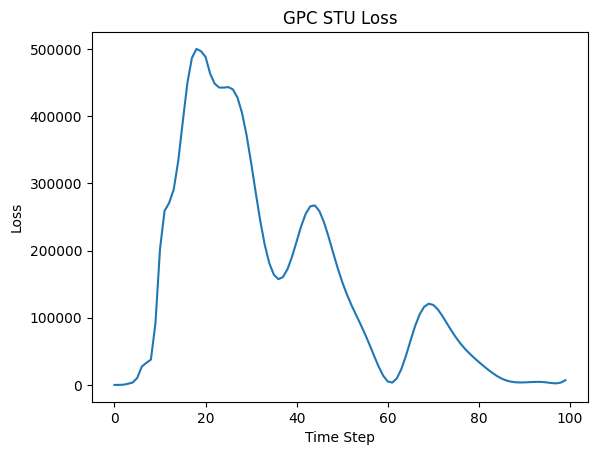

In [61]:
plot_loss(gpc_wstu, "GPC STU Loss", save_path="figures/gpc_stu_loss2.png" )

/home/sd0937/spectral_control/spectral_control/OSFC/osfcNFwSTU.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("K", torch.tensor(lqr(A, B, Q, R), dtype=torch.float32))


OSC_w_STU Model Runtime: 55.2798 seconds


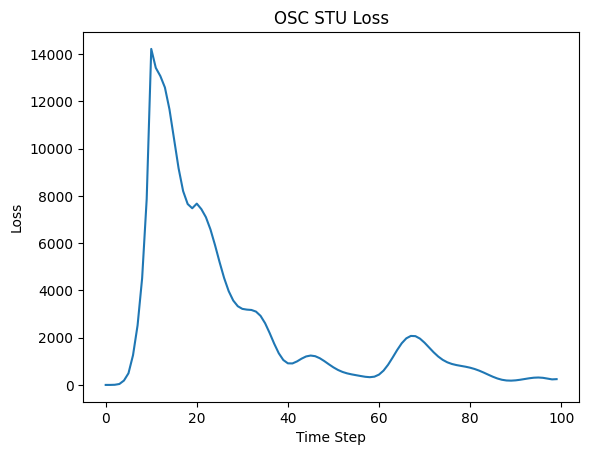

In [60]:
# OSFC Experiments (Main OSC is from osfcNF.py and STU one is in osfcNFwSTUSignal.py)

# Define system parameters
d, n = 10, 4  # Example dimensions
A = make_diagonalizable_matrix(d)
# A_compl = make_diagonalizable_matrix_complex(d)
B = np.random.randn(d, n)
Q = make_positive_semidefinite(d) 
R = make_positive_semidefinite(n)


# Base dimensions
# dx_base, du_base = 2, 1
# blocks = 5  # So final dx = 2 * 5 = 10, du = 1 * 5 = 5

# # Define small system matrices
# A_small = np.array([[1.0, 1.0], [0.0, 1.0]])
# B_small = np.array([[0.0], [1.0]])
# Q_small = np.eye(dx_base)
# R_small = np.eye(du_base)

# # Create block-diagonal matrices
# A = block_diag(*([A_small] * blocks))     # Shape (10, 10)
# B = block_diag(*([B_small] * blocks))     # Shape (10, 5)
# Q = block_diag(*([Q_small] * blocks))     # Shape (10, 10)
# R = block_diag(*([R_small] * blocks))     # Shape (5, 5)


# PARAMETERS
h = 10         # Number of eigenpairs
m = 20      # order of log T (for the new Hankel Matrix) (only way I can achieve "going down" if this is large
gamma = 0.1 # should be very small (less than 2/3 for marginally stable systems) (check 0.2) for the GPC to be smoother
eta =  0.001  # Step size
T = 100


osc = OSC(A, B, Q, R, h,  m, gamma, eta, T, name="OSC", nl=False)
osc_nl = OSC(A, B, Q, R, h,  m, gamma, eta , T, name="OSC", nl=True)
osc_wstu = OSCwSTU(A, B, Q, R, h, m, gamma, eta, T, name="OSC STU")

# OSC
# start_time = time.time()
# osc.run()
# end_time = time.time()
# print(f"OSC Model Runtime: {end_time - start_time:.4f} seconds")

# # OSC_NL
# start_time = time.time()
# osc_nl.run()
# end_time = time.time()
# print(f"OSC NL Model Runtime: {end_time - start_time:.4f} seconds")

# OSC_w_STU
start_time = time.time()
osc_wstu.run()
end_time = time.time()
print(f"OSC_w_STU Model Runtime: {end_time - start_time:.4f} seconds")


# plot_loss(osc, "OSC Loss")
# plot_loss(osc_nl, "OSC NL Loss")
plot_loss(osc_wstu, "OSC STU Loss")

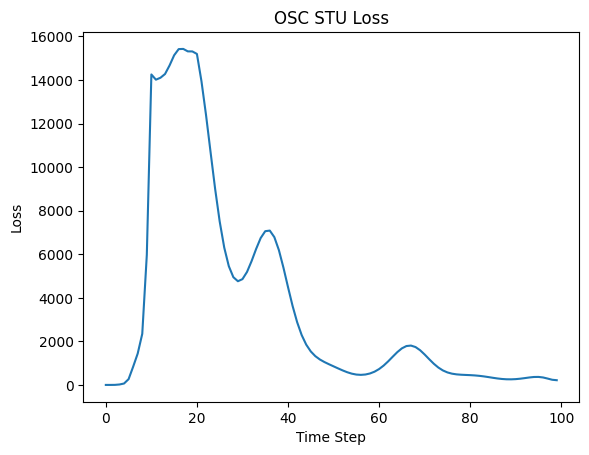

In [50]:
plot_loss(osc_wstu, "OSC STU Loss", save_path="figures/osc_stu_loss.png")

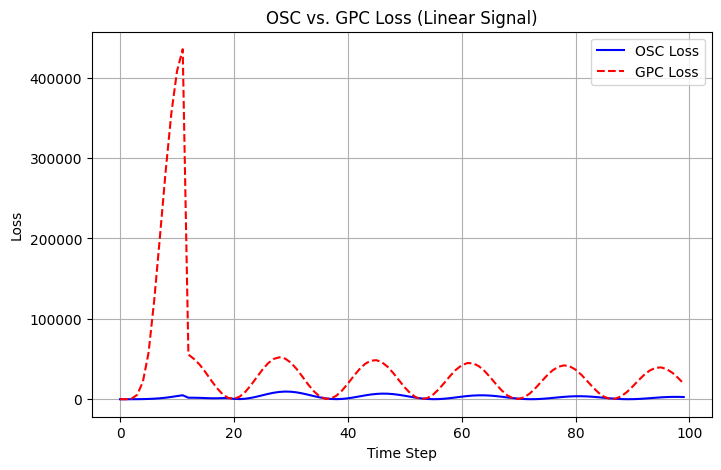

In [56]:
compare_losses([osc, gpc], "OSC vs. GPC Loss (Linear Signal)", save_path="figures/osc_vs_gpc_loss3.png")


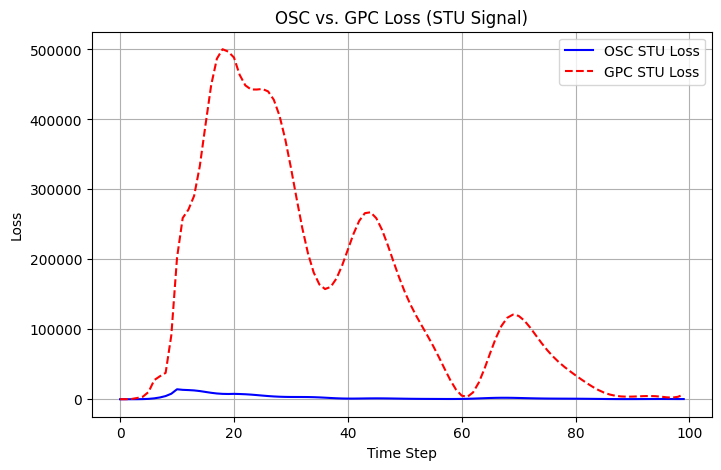

In [62]:
compare_losses([osc_wstu, gpc_wstu], "OSC vs. GPC Loss (STU Signal)", save_path="figures/osc_vs_gpc_loss_stu2.png")

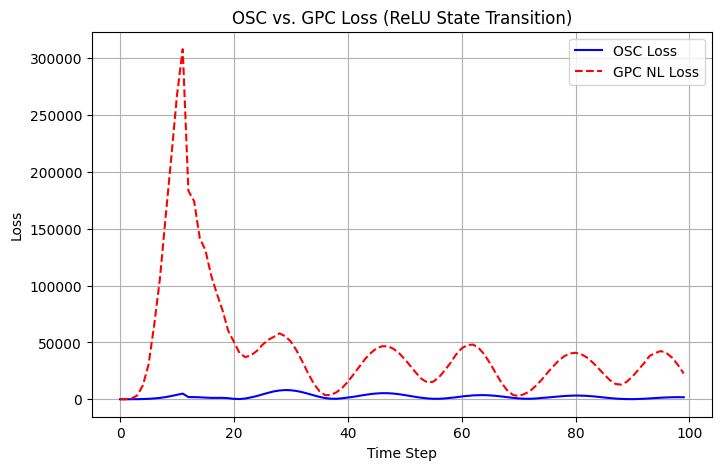

In [54]:
compare_losses([osc_nl, gpc_nl], "OSC vs. GPC Loss (ReLU State Transition)", save_path="figures/oscNL_vs_gpcNL_loss2.png")

In [12]:
compare_losses([lqr, gpc, osc], "LQR vs. GPC vs. OSC Loss")

NameError: name 'lqr' is not defined

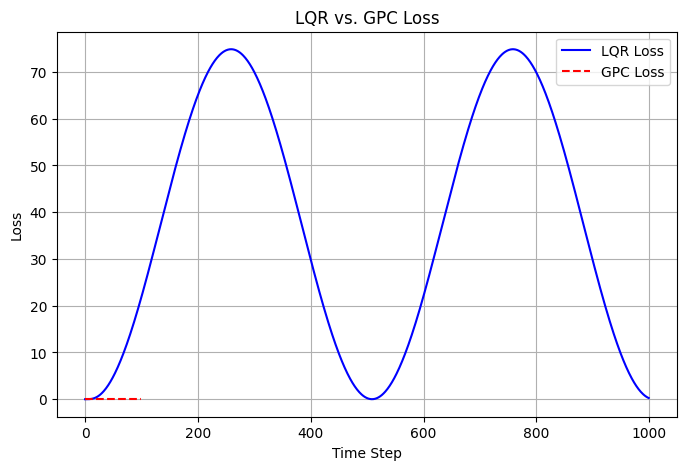

In [ ]:
compare_losses([lqr, gpc], "LQR vs. GPC Loss")

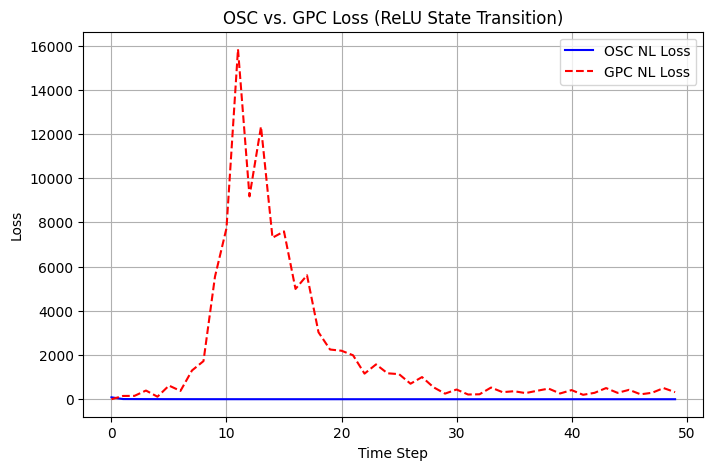

In [105]:
compare_losses([osc_nl, gpc_nl], "OSC vs. GPC Loss (ReLU State Transition)")